In [40]:
'''
1. Import libraries
'''

import numpy as np
import random
import glob
import matplotlib.pyplot as plt

from tqdm import tqdm
from music21 import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.models import Sequential, Model, load_model 

In [41]:
'''
2. Read and parse the midi files
'''

# define function to read and parse midi files
def read_files(file):

  # create an empty array to store notes
  notes = []
  notes_to_parse = None

  # parse the midi file
  midi = converter.parse(file)

  # seperate all instruments from the file
  instrmt = instrument.partitionByInstrument(midi)

  for part in instrmt.parts:
    # fetch data only of Piano instrument
    if 'Piano' in str(part):
      notes_to_parse = part.recurse()

      # iterate over all the parts of sub stream elements
      # if element's type is chord, split them into notes
      for element in notes_to_parse:
        if type(element) == note.Note:
          notes.append(str(element.pitch))
        elif type(element) == chord.Chord:
          notes.append('.'.join(str(n) for n in element.normalOrder))

  # return the list of notes
  return notes

# retrieve paths recursively from inside the directories/files
file_path = ["jazz_midi"]
all_files = glob.glob('data/' + file_path[0] + '/*.mid', recursive=True)

# reading each midi file into a list of lists
notes_array = []
# Loop through each file in all_files, using tqdm to show progress
for file in tqdm(all_files, position=0, leave=True):
    file_notes = read_files(file)
    notes_array.append(file_notes)
# Convert the list of lists to a numpy array
notes_array = np.array(notes_array)

100%|██████████| 140/140 [01:10<00:00,  1.99it/s]
/var/folders/ky/w3c_7css5qbdm741fxkfb3gw0000gn/T/ipykernel_63492/1305682806.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  notes_array = np.array(notes_array)


In [42]:
'''
3. Explore the dataset
'''

# count unique notes
# flatten 'notes_array' into a single list
notes = sum(notes_array, []) 
# remove any duplicate note
unique_notes = list(set(notes))
print("Unique Notes:", len(unique_notes))

# notes with their count (key: a unique note, value: count of the note)
note_count = dict(map(lambda x: (x, notes.count(x)), unique_notes))

# get the threshold count
print("\nNotes Count")
for i in range(0, 100, 5):
  print("≥", i, ":", len(list(filter(lambda x: x[1] >= i, note_count.items()))))

Unique Notes: 730

Notes Count
≥ 0 : 730
≥ 5 : 409
≥ 10 : 321
≥ 15 : 285
≥ 20 : 259
≥ 25 : 238
≥ 30 : 220
≥ 35 : 205
≥ 40 : 191
≥ 45 : 179
≥ 50 : 167
≥ 55 : 157
≥ 60 : 154
≥ 65 : 148
≥ 70 : 141
≥ 75 : 138
≥ 80 : 131
≥ 85 : 127
≥ 90 : 124
≥ 95 : 118


In [43]:
''' 
4. Pre-process the data and create two dictionaries for later use
'''

# To make the model training easier, we need to filter and keep notes 
# greater than a threshold which at least 50% unique notes appreared
filter_notes = dict(filter(lambda x: x[1] >= 5, note_count.items()))

# create new notes using the filtered notes
new_notes = []
for sublist in notes_array:
    filtered_notes = []
    for note in sublist:
        # If the note is frequent enough, add it to the filtered_notes sublist
        if note in filter_notes:
            filtered_notes.append(note)
    
    # Add the filtered_notes sublist to new_notes list
    new_notes.append(filtered_notes)


# create dictionary (key: note index, value: note)
ind2note = dict(enumerate(filter_notes))

# create dictionary (key: note, value: note index)
note2ind = dict(map(reversed, ind2note.items()))

In [44]:
'''
5. Input and output sequence for model
'''

# timestep: if we traverse 20 notes of our input sequence
# then the 51th note will be the output for that sequence
timesteps = 20

# store values of input and output
input = []
output = []

for i in new_notes:
  for j in range(0, len(i) - timesteps):
    # input will be the current index + timestep
    inp = i[j: j + timesteps]
    # output will be the next index after timestep
    out = i[j + timesteps]

    # append the index value of respective notes 
    input.append(list(map(lambda x: note2ind[x], inp)))
    output.append(note2ind[out])

input_new = np.array(input) 
output_new = np.array(output)

In [45]:
'''
6. Reshape array for model and split the data into 'training' and 'testing' sets
'''

# reshape input to a 3-D array for the LSTM model
input_new = np.reshape(input_new, (len(input_new), timesteps, 1))
# reshape output to a 2-D array for the LSTM model
output_new = np.reshape(output_new, (-1, 1))

# split the input and value into training and testing sets
# 80% for training and 20% for testing sets
input_train, input_test, output_train, output_test = train_test_split(input_new, output_new, test_size = 0.2, random_state = 114514)

In [46]:
'''
7. Build the LSTM model
'''

# create the model
model = Sequential()

# create two stacked LSTM layer with the latent dimension of 256
model.add(LSTM(256, return_sequences = True, input_shape = (input_new.shape[1], input_new.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dropout(0.3))
model.add(Dense(256, activation = 'relu'))

# fully connected layer for the output with softmax activation
model.add(Dense(len(note2ind), activation='softmax'))

# show the model description
model.summary()

2024-04-17 03:05:30.515032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-17 03:05:30.525093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-17 03:05:30.533021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 256)           264192    
                                                                 
 dropout_4 (Dropout)         (None, 20, 256)           0         
                                                                 
 lstm_5 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 409)               105113    
                                                                 
Total params: 960,409
Trainable params: 960,409
Non-tr

2024-04-17 03:05:30.725379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-17 03:05:30.725842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-17 03:05:30.726281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [47]:
'''
8. Train the LSTM model
'''

# compile the model using Adam optimizer
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# train the model on training sets and validate on testing sets
# and record the training log
log = model.fit(
    input_train, output_train,
    batch_size = 256, epochs = 400, 
    validation_data = (input_test, output_test))

Epoch 1/400


2024-04-17 03:05:35.563870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-17 03:05:35.564768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-17 03:05:35.565565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 19/136 [===>..........................] - ETA: 34s - loss: 5.4859 - accuracy: 0.0214

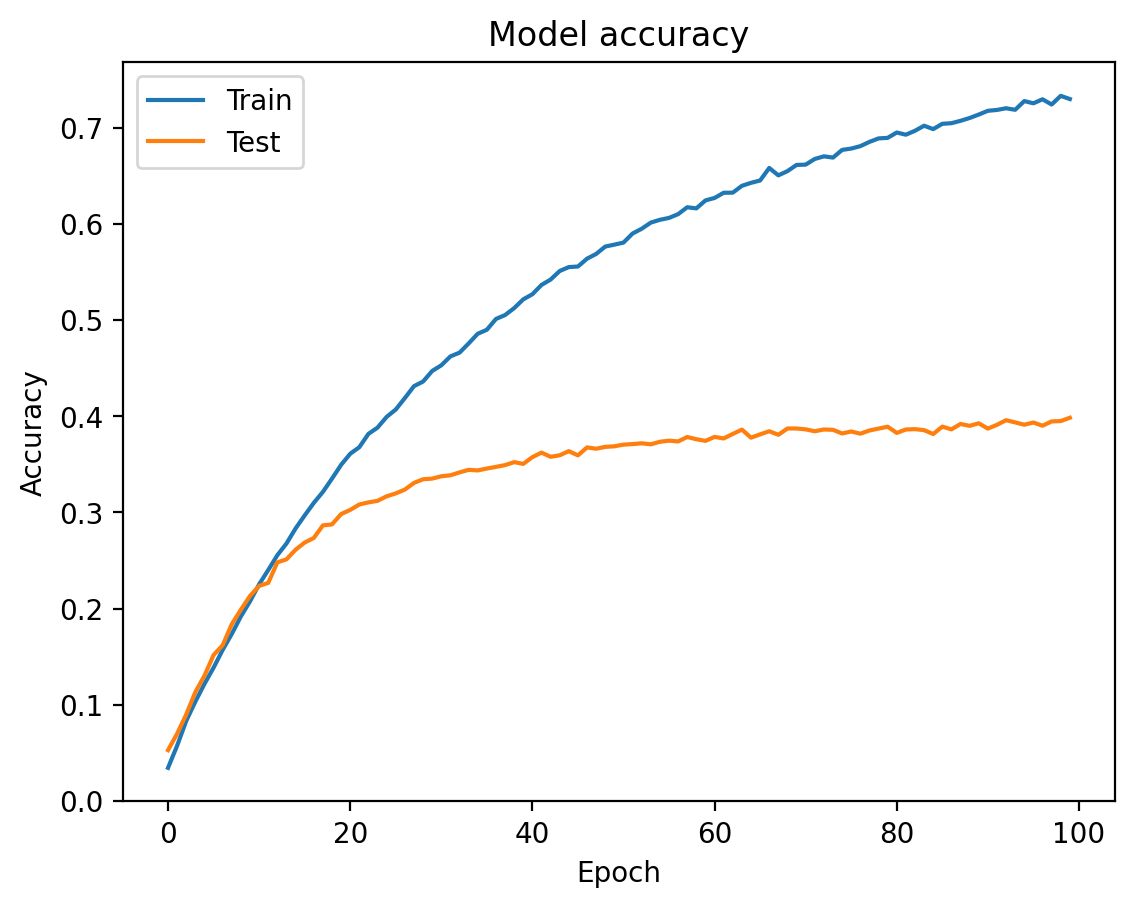

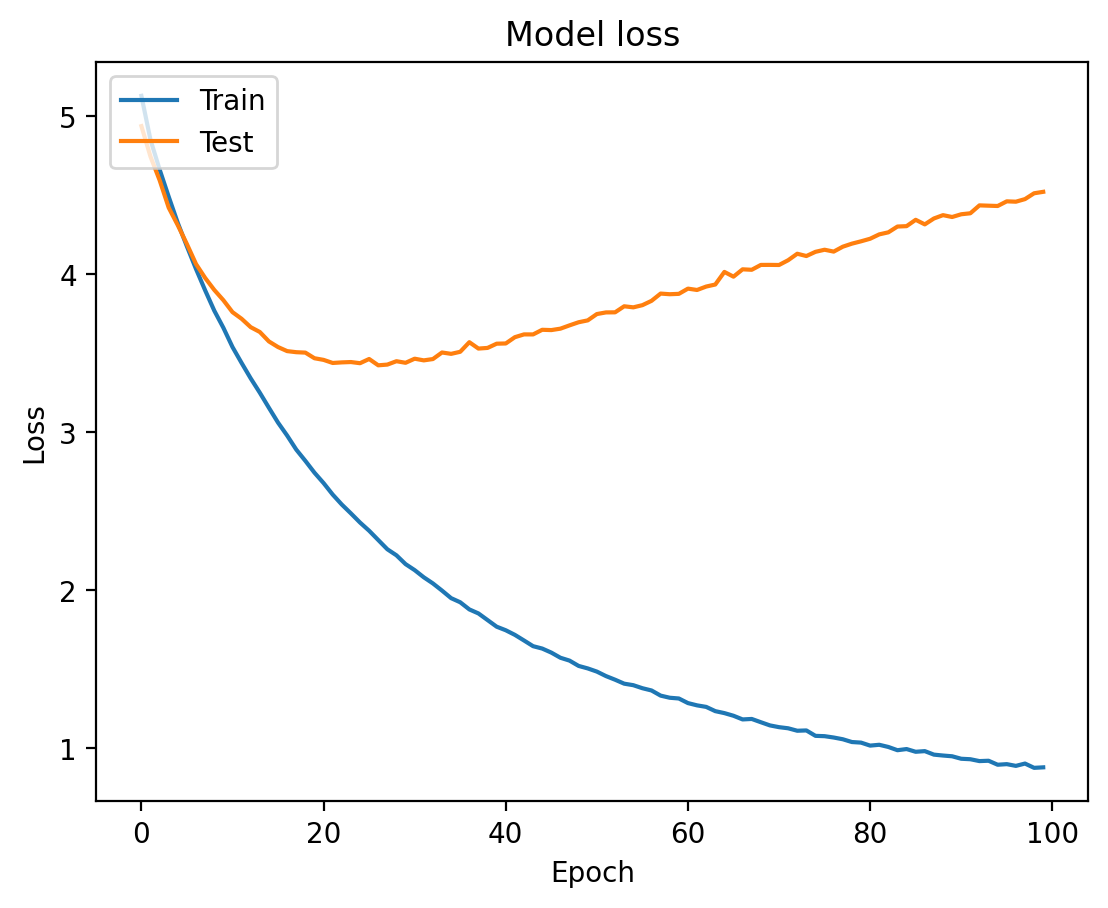

In [30]:
'''
9. Plot the training log data
'''

# Plot training & validation accuracy values
plt.plot(log.history['accuracy'])
if 'val_accuracy' in log.history:
    plt.plot(log.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(log.history['loss'])
if 'val_loss' in log.history:
    plt.plot(log.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [31]:
'''
10. save the model for predictions
'''

model.save("jazz_model2")

2024-04-16 23:05:13.368466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-16 23:05:13.370629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-16 23:05:13.371516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: jazz_model/assets


INFO:tensorflow:Assets written to: jazz_model/assets


In [38]:
'''
11. Inference (sampling) phase
'''

# load the model
model = load_model("jazz_model2")

# generate random index
index = np.random.randint(0, len(input_test) - 1)
# get the data (initial seed) of generated index from x_test
music_pattern = input_test[index]

# create an array to store predicted notes
out_pred = [] 

# iterate till 100 note is generated
for i in range(100):

  # reshape the music pattern to fit the input shape expected by the LSTM model
  music_pattern = music_pattern.reshape(1, len(music_pattern), 1)
  
  # get the maximum probability value from the predicted output
  pred_index = np.argmax(model.predict(music_pattern))

  # get the note using predicted index and
  # append to the output prediction list
  out_pred.append(ind2note[pred_index])
  music_pattern = np.append(music_pattern, pred_index)
  
  # update the music pattern with one timestep ahead (remove the oldest note)
  # this keeps the length of the music_pattern consistent 
  # as it simulates moving through time in the generated music piece
  music_pattern = music_pattern[1:]

2024-04-16 23:08:01.936411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2024-04-16 23:08:01.936481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2024-04-16 23:08:01.936527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 397ms/step


2024-04-16 23:08:03.763766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-16 23:08:03.764296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-16 23:08:03.764744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 17ms/step


In [39]:
'''
12. Save the file to midi
'''

# create an array to store output notes
output_notes = []

# iterates over the out_pred list
for offset, pattern in enumerate(out_pred):

  # if pattern is a chord instance
  if ('.' in pattern) or pattern.isdigit():
    # split notes from the chord
    notes_in_chord = pattern.split('.')

    notes = []
    for current_note in notes_in_chord:
        i_curr_note = int(current_note)
        # cast the current note to Note object and append the current note 
        new_note = note.Note(i_curr_note)
        new_note.storedInstrument = instrument.Piano()
        notes.append(new_note)
    
    # cast the current note to Chord object
    # offset will be 1 step ahead from the previous note as it will prevent notes to stack up 
    new_chord = chord.Chord(notes)
    new_chord.offset = offset
    output_notes.append(new_chord)
  
  # if pattern is not a chord instance
  else:
    # cast the pattern to Note object apply the offset and 
    # append the note
    new_note = note.Note(pattern)
    new_note.offset = offset
    new_note.storedInstrument = instrument.Piano()
    output_notes.append(new_note)

# save the midi file 
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp = 'pred_music_jazz.mid')

'pred_music_jazz.mid'